### Adversarial Attacks on Hybrid Classical-Quantum Models

In [ ]:
!pip install '/content/qausalml-0.7-py3-none-any.whl'
!pip install pennylane==0.29.1

In [1]:
# DATASET
!wget 'https://github.com/tqausal/qadversarial/raw/main/histo_1000.zip'

!unzip -qq 'histo_1000.zip'

--2024-04-06 08:37:41--  https://github.com/tqausal/qadversarial/raw/main/histo_1000.zip
Resolving github.com (github.com)... 140.82.114.3
Connecting to github.com (github.com)|140.82.114.3|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/tqausal/qadversarial/main/histo_1000.zip [following]
--2024-04-06 08:37:42--  https://raw.githubusercontent.com/tqausal/qadversarial/main/histo_1000.zip
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 7721963 (7.4M) [application/zip]
Saving to: ‘histo_1000.zip’

histo_1000.zip      100%[===================>]   7.36M  --.-KB/s    in 0.09s   

2024-04-06 08:37:42 (85.1 MB/s) - ‘histo_1000.zip’ saved [7721963/7721963]



In [ ]:
from qausalml.classifier.test import test_model
from qausalml.classifier.train import train_model
from qausalml.classifier.utility import (visualize_quantum_circuit,
																		print_q_device_info,
																		create_hybrid_model,
																		data_helper)

import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np

from qausalml.adversarial.estimators.classification import PyTorchClassifier
from qausalml.adversarial.attacks.evasion import FastGradientMethod

In [ ]:
# RESNET-18:Model
ml_params={
		"lr":0.002,
		"optimizer":"Adam",
		"step_size": 6,
		"model_name": "resnet18",
		"batch_size":32,
		"num_epochs":20,
		"n_classes":2
}

In [ ]:
quantum_circuit_params={
		"ip":0,
		"front_layer":"5",
		"op":1,
		"last_layer": "6",
		"entanglement_layer":0,
		"middle_layer": "4",
		"measurement":0,
		"fmap_depth":3,
		"var_depth":3,
		"fmap_id":100,
		"n_qubits":4
}

In [ ]:
q_device_params={
		"use_real_q_hw":False,
		"device_platform":"pennylane",
		"api_token":"",
		"real_q_device_name":"ibmq_belem"
}

In [ ]:
data_params={
		"data_dir":"histo_1000/",
		"trained_model_path": "/content/model_resnet18_2023_07_07_10_45.pth"
}

(<Figure size 1900x500 with 1 Axes>, <Axes: >)

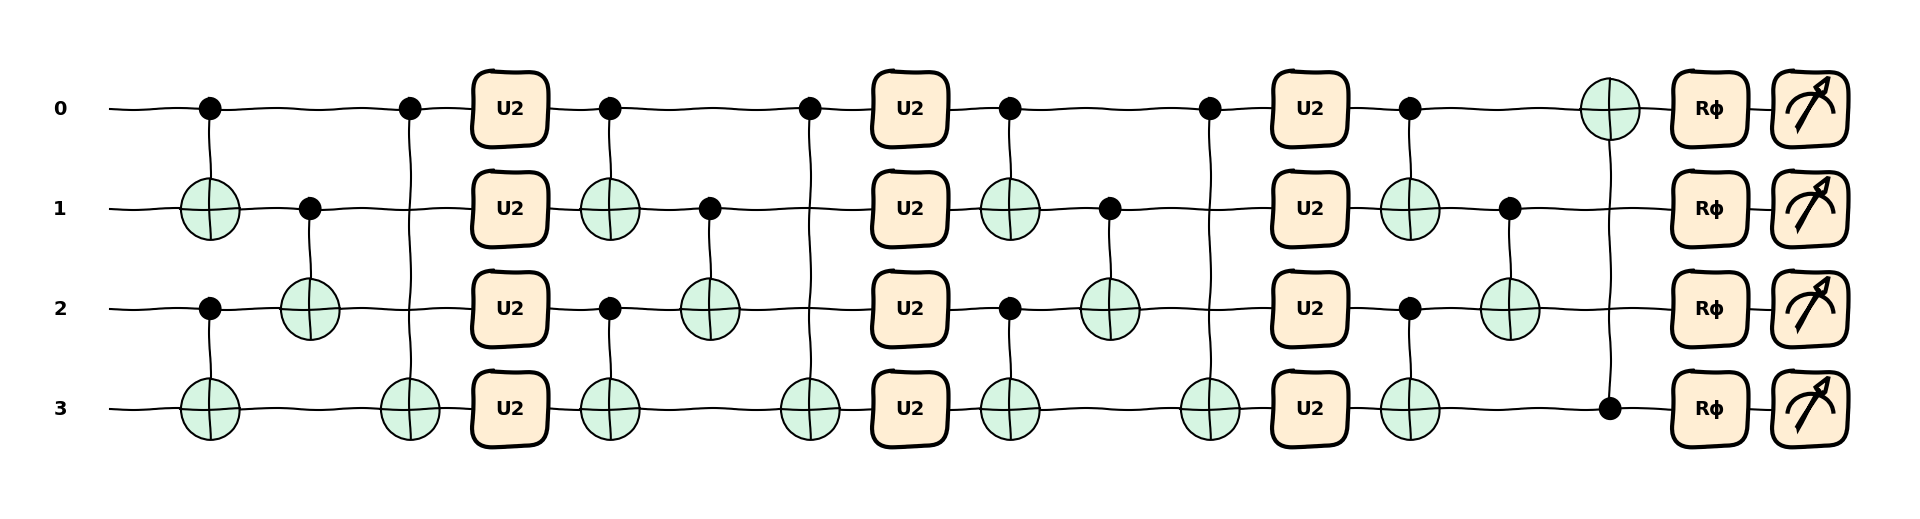

In [ ]:
visualize_quantum_circuit(quantum_circuit_params)

In [ ]:
model=create_hybrid_model(quantum_circuit_params,q_device_params,ml_params,data_params)

[0, '75', 1, '6', 0, '4', 0, 3, 3, 'Hybrid', 100]


Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 106MB/s]


Device is: cpu
Pretrained modelfound...


In [ ]:
d1=data_helper(model,data_params['data_dir'],ml_params['model_name'])
X_train,Y_train,X_test,Y_test=d1.get_data_arrays()
print(X_train.shape,Y_train.shape,X_test.shape,Y_test.shape)

(800, 3, 224, 224) (800,) (200, 3, 224, 224) (200,)


In [ ]:
criterion=nn.CrossEntropyLoss()
optimizer=optim.Adam(model.parameters(),lr=ml_params['lr'])

classifier = PyTorchClassifier(
  model=model,
  clip_values=(X_test.min(), X_test.max()),
  loss=criterion,
  optimizer=optimizer,
  input_shape=(3, X_test.shape[2], X_test.shape[3]),
  nb_classes=2,
)

# ACCURACY WITHOUT ANY ATTACK
predictions = classifier.predict(X_test[100:])
accuracy = np.sum(np.argmax(predictions, axis=1) == Y_test[100:]) / len(Y_test[100:])
print("Accuracy on benign test examples: {}%".format(accuracy * 100))

Accuracy on benign test examples: 91.0%


In [ ]:
# GENERATE ADV: FGSM: 0.05
attack_fgm_05 = FastGradientMethod(estimator=classifier, eps=0.05)
X_test_fgm05 = attack_fgm_05.generate(x=X_test)
print(X_test_fgm05.shape)
predictions = classifier.predict(X_test_fgm05)
accuracy = np.sum(np.argmax(predictions, axis=1) == Y_test) / len(Y_test)
print("Accuracy on adversarial FGSM examples: {}%".format(accuracy * 100))

(200, 3, 224, 224)
Accuracy on adversarial FGSM examples: 46.0%


In [ ]:
# DEEP FOOL EPSILON: 0.05
from qausalml.adversarial.attacks.evasion import DeepFool
df_005=DeepFool(
    classifier=classifier,
    epsilon=0.05,
    nb_grads=2
)
X_test_adv_df005=df_005.generate(X_test)
print(X_test_adv_df005.shape)
predictions = classifier.predict(X_test_adv_df005)
accuracy = np.sum(np.argmax(predictions, axis=1) == Y_test) / len(Y_test)
print("Accuracy on adversarial DeepFool examples: {}%".format(accuracy * 100))

In [ ]:
# PGD_ATTACK EPS=0.05
from qausalml.adversarial.attacks.evasion import ProjectedGradientDescentPyTorch
pgd_attack_005=ProjectedGradientDescentPyTorch(estimator=classifier,
                                        eps=0.05,
                                        batch_size=64)
X_test_pgd_005=pgd_attack_005.generate(X_test)
print(X_test_pgd_005.shape)
predictions = classifier.predict(X_test_pgd_005)
accuracy = np.sum(np.argmax(predictions, axis=1) == Y_test) / len(Y_test)
print("Accuracy on adversarial PGD examples: {}%".format(accuracy * 100))